In [1]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import struct
from warnings import warn
from tqdm import tqdm

from ptlflow.utils.flow_utils import flow_read, flow_to_rgb

/opt/conda/envs/deblur/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[!!alt_cuda_corr is not compiled!!]


## Flow Functions

In [ ]:
def caculate_PSNR(sharp_path, blur_path):
    img1 = Image.open(sharp_path).convert('RGB')
    img2 = Image.open(blur_path).convert('RGB')

    img1 = np.array(img1).astype(np.float64)
    img2 = np.array(img2).astype(np.float64)

    

    # MSE 계산
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        # 두 이미지가 완전히 동일한 경우
        return float('inf')

    # 최대 픽셀 값
    max_pixel = 1. if img1.max() <= 1 else 255.

    # PSNR 계산
    psnr = 20. * np.log10(max_pixel / np.sqrt(mse))
    
    # print(psnr)
    return psnr


def normalize_flow_to_tensor(flow):
    """
    Normalize the optical flow and compute the 3D tensor C with x, y, and z components.

    Parameters:
    - flow: 2D array representing optical flow.

    Returns:
    - C: 3D tensor with shape (H, W, 3), where C[..., 0] is x, C[..., 1] is y, and C[..., 2] is z.
    """
    # Calculate the magnitude of the flow vectors
    u, v = flow[:,:,0], flow[:,:,1]
    magnitude = np.sqrt(u**2 + v**2)
    
    # Avoid division by zero by setting small magnitudes to a minimal positive value
    magnitude[magnitude == 0] = 1e-8
    
    # Normalize u and v components to get unit vectors for x and y
    x = u / magnitude
    y = v / magnitude

    # Normalize the magnitude to [0, 1] range for the z component
    z = magnitude / 100
    z = np.clip(z,0,1)
    z = z * 2 - 1

    # Stack x, y, and z to create the 3D tensor C with shape (H, W, 3)
    C = np.stack((x, y, z), axis=-1)

    return C

def tensor_to_original_flow(C):

    
    """
    Input:
    - C: x [0, 1]
         y [0, 1]
         z [0, 1]

    Returns:
    - flow: 2D array representing optical flow with shape (H, W, 2).
    """
    # Extract x, y, and z components
    x, y, z = C[..., 0], C[..., 1], C[..., 2]

    # Convert x,y from [0, 1] range back to [-1, 1] range
    x = x*2 - 1
    y = y*2 - 1

    # keep z [0, 1] range
    z = z


    # Denormalize z to get the magnitude of the flow vectors
    magnitude = z * 100

    # Compute original u and v components using magnitude and x, y unit vectors
    u = x * magnitude
    v = y * magnitude

    # Stack u and v to create the original 2D optical flow with shape (H, W, 2)
    flow = np.stack((u, v), axis=-1)

    return flow


def augment_flow(flow, command):
    """
    Augment a concatenated flow tensor with shape (H, W, 10) based on the specified command.

    Parameters:
    - flow: 3D array representing concatenated optical flows with shape (H, W, 10).
    - command: String specifying the augmentation ('hflip', 'vflip', 'rot90').

    Returns:
    - flow: Augmented flow tensor with shape (H, W, 10).
    """
    # Split the flow into individual components
    flows = [flow[..., i:i+2] for i in range(0, flow.shape[2], 2)]

    # Apply augmentation to each flow component
    augmented_flows = []
    for f in flows:
        if command == 'hflip':  # horizontal
            f = cv2.flip(f, 1)
            f[:, :, 0] *= -1

        elif command == 'vflip':  # vertical
            f = cv2.flip(f, 0)
            f[:, :, 1] *= -1

        elif command == 'rot90':
            f = np.rot90(f)
            f = f[:, :, [1, 0]]
            f[:, :, 1] *= -1

        else:
            raise ValueError('Wrong command!')

        augmented_flows.append(f)

    # Concatenate the augmented flows back into a single tensor
    flow = np.concatenate(augmented_flows, axis=-1)

    return flow





# Vis version C

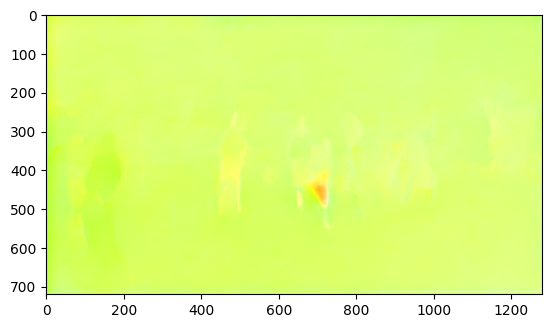

In [3]:
flow = np.load('tt.np.npy')
two_flow = tensor_to_original_flow(flow)
rgb_flow = flow_to_rgb(two_flow)
rgb_flow = Image.fromarray(rgb_flow)
plt.imshow(rgb_flow)
plt.show()

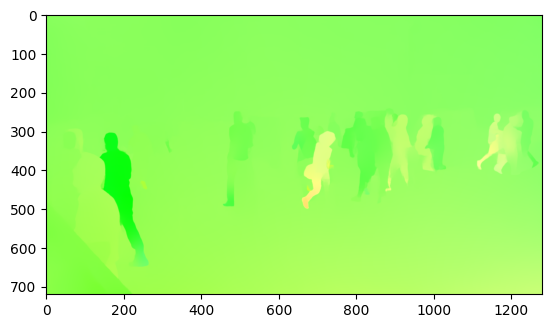

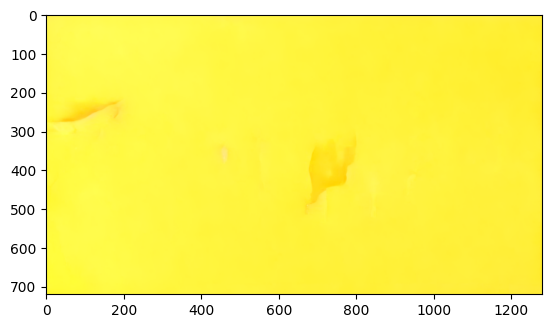

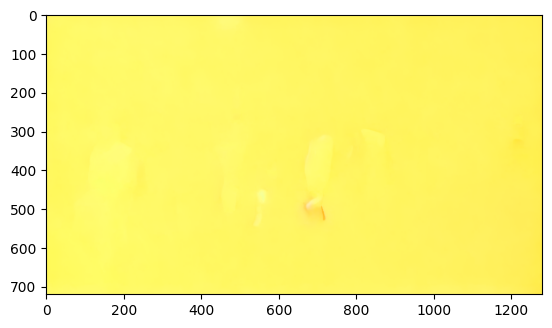

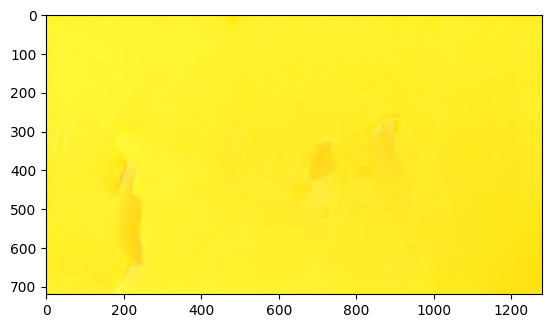

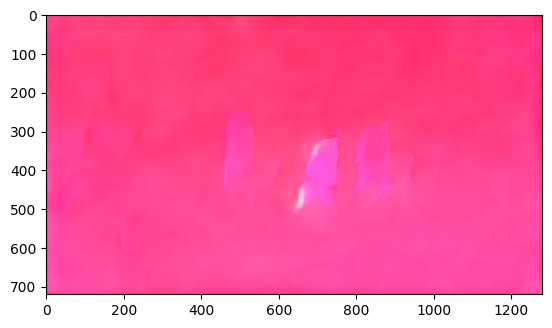

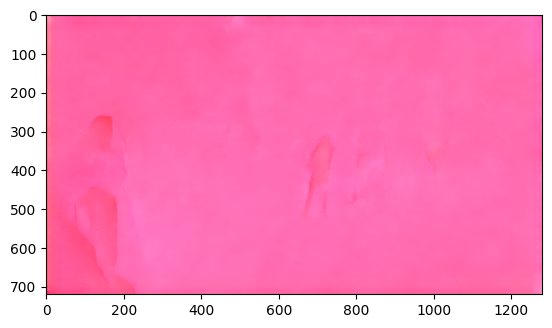

In [ ]:
scene = '000001'

gt_flow_path = f'/workspace/data/Gopro_my/test/{scene}/flow/flows/{scene}.flo'
gt_flow = flow_read(gt_flow_path)
rgb_flow = flow_to_rgb(gt_flow)
rgb_flow = Image.fromarray(rgb_flow)
plt.imshow(rgb_flow)
plt.show()

three_flow_path = f'/workspace/data/results/C/Gopro/test/Gopro/{scene}/'
three_flow_folder = os.listdir(three_flow_path)

for flow in three_flow_folder:
    flow_path = os.path.join(three_flow_path,flow)

    three_flow = np.load(flow_path)['arr_0']
    two_flow = tensor_to_original_flow(three_flow)

    rgb_flow = flow_to_rgb(two_flow)
    rgb_flow = Image.fromarray(rgb_flow)
    plt.imshow(rgb_flow)
    plt.show()



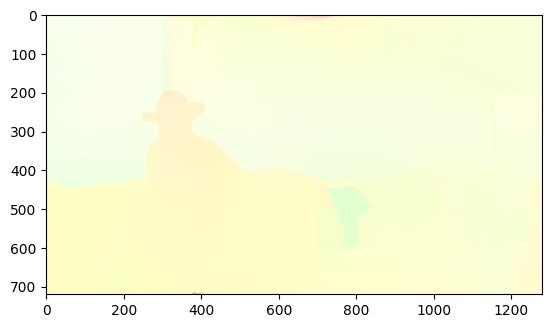

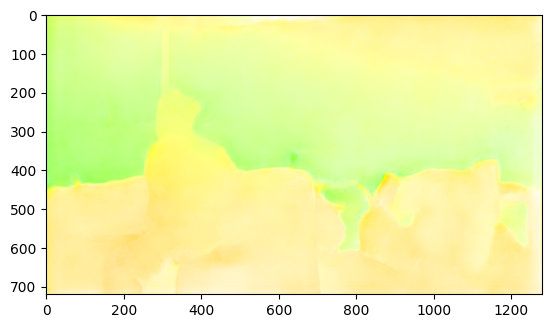

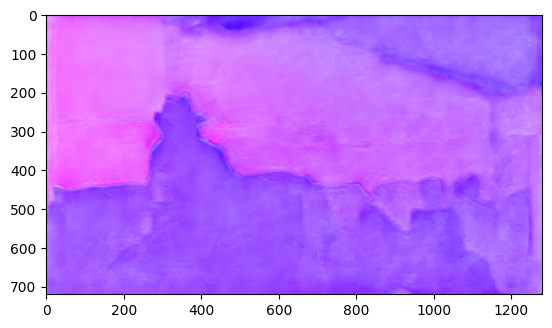

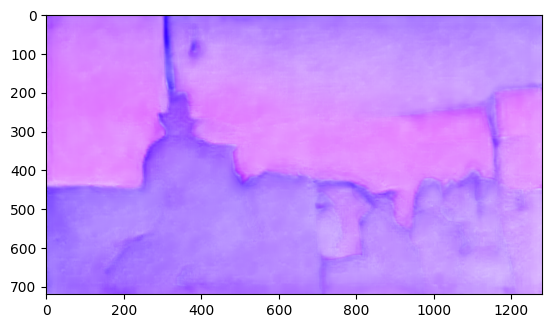

In [70]:
scene = '000650'

gt_flow_path = f'/workspace/data/Gopro_my/train/{scene}/flow/flows/{scene}.flo'
gt_flow = flow_read(gt_flow_path)
rgb_flow = flow_to_rgb(gt_flow)
rgb_flow = Image.fromarray(rgb_flow)
plt.imshow(rgb_flow)
plt.show()

three_flow_path = f'/workspace/data/results/C/Gopro/train/{scene}/'
three_flow_folder = os.listdir(three_flow_path)

for flow in three_flow_folder:
    flow_path = os.path.join(three_flow_path,flow)

    three_flow = np.load(flow_path)['arr_0']
    two_flow = tensor_to_original_flow(three_flow)

    rgb_flow = flow_to_rgb(two_flow)
    rgb_flow = Image.fromarray(rgb_flow)
    plt.imshow(rgb_flow)
    plt.show()



In [ ]:
EF_path = '/workspace/data/jinseon/EFNet_test/visualization/EFNet_test'
scenes = os.listdir(EF_path)
scenes.sort()

with open('tt.txt', 'a') as file:
    for scene in scenes:
        folder_path = os.path.join(EF_path,scene)
        imgs = os.listdir(folder_path)
        imgs.sort()
        for img in imgs:
            tag = img.split('.')
            if tag[0][-1] == 't':
                gt_path = os.path.join(folder_path,img)
                # print(gt_path)
            else:
                EF_img_path = os.path.join(folder_path,img)
                ours_img_path = EF_img_path.replace('EFNet_test', 'dilatedConv_HWCweight_2stages_batch24_8_test')
                gt_path = EF_img_path.replace(f'{img[:-4]}', f'{img[:-4]}_gt')

                EF_img = cv2.cvtColor(cv2.imread(EF_img_path), cv2.COLOR_BGR2RGB)
                ours_img = cv2.cvtColor(cv2.imread(ours_img_path), cv2.COLOR_BGR2RGB)
                gt_img = cv2.cvtColor(cv2.imread(gt_path), cv2.COLOR_BGR2RGB)

                EF_psnr = caculate_PSNR(EF_img_path, gt_path)
                ours_psnr = caculate_PSNR(ours_img_path, gt_path)

                
                sub = ours_psnr - EF_psnr
                # file.write(f'{sub}    {ours_img_path}\n')
                new_EF_path = folder_path.split('/')[-1] + '_' + img[:-4] + '_EF.png'
                new_ours_path = folder_path.split('/')[-1] + '_' + img[:-4] + '_OURS.png'

                if sub > 1:
                    cv2.imwrite(f'sub/{new_EF_path}', EF_img[:,:,::-1])
                    cv2.imwrite(f'sub/{new_ours_path}', ours_img[:,:,::-1])
        



In [17]:
import glob

def caculate_PSNR(sharp_path, blur_path):
    img1 = Image.open(sharp_path).convert('RGB')
    img2 = Image.open(blur_path).convert('RGB')

    img1 = np.array(img1).astype(np.float64)
    img2 = np.array(img2).astype(np.float64)

    

    # MSE 계산
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        # 두 이미지가 완전히 동일한 경우
        return float('inf')

    # 최대 픽셀 값
    max_pixel = 1. if img1.max() <= 1 else 255.

    # PSNR 계산
    psnr = 20. * np.log10(max_pixel / np.sqrt(mse))
    
    # print(psnr)

    return psnr


mother_path = '/workspace/data/FFTformer/results/EB_FFTformer_Gen/visualization/EB_FFTformer_Gen'
imgs = glob.glob(os.path.join(mother_path, '*.png'))
imgs.sort()